<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools


<a id='1.4'></a>
## 2.4. Create Folders

In [7]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
# check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [9]:
TRAIN_START_DATE = '2002-08-01'
TRAIN_END_DATE = '2007-07-01'
TRADE_START_DATE = '2007-07-01'
TRADE_END_DATE = '2019-10-31'

In [4]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['IVV', 'IEF']).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8686, 8)


In [5]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2002-08-01,82.540001,82.900002,82.519997,46.281357,71400,IEF,3
1,2002-08-01,91.099998,91.230003,88.449997,59.666157,200300,IVV,3
2,2002-08-02,83.019997,83.699997,82.900002,46.638859,120300,IEF,4
3,2002-08-02,88.699997,88.849998,85.720001,58.344730,314600,IVV,4
4,2002-08-05,83.680000,83.919998,83.529999,46.873444,159300,IEF,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [10]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [11]:
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (4342, 8)
Successfully added vix


In [12]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2002-08-01,82.540001,82.900002,82.519997,46.281357,71400,IEF,3,0.000000,46.965692,45.954524,100.000000,66.666667,100.000000,46.281357,46.281357,36.950001
1,2002-08-01,91.099998,91.230003,88.449997,59.666157,200300,IVV,3,0.000000,46.965692,45.954524,100.000000,66.666667,100.000000,59.666157,59.666157,36.950001
2,2002-08-02,83.019997,83.699997,82.900002,46.638859,120300,IEF,4,0.008021,46.965692,45.954524,100.000000,66.666667,100.000000,46.460108,46.460108,41.290001
3,2002-08-02,88.699997,88.849998,85.720001,58.344730,314600,IVV,4,-0.029647,60.874223,57.136664,0.000000,-66.666667,100.000000,59.005444,59.005444,41.290001
4,2002-08-05,83.680000,83.919998,83.529999,46.873444,159300,IEF,0,0.017495,47.194211,46.001562,100.000000,89.111445,100.000000,46.597886,46.597886,45.080002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679,2019-10-25,301.450012,303.899994,301.420013,287.124603,2515700,IVV,4,1.560279,289.444646,273.803596,56.284025,102.013308,11.914229,282.302016,279.429467,12.650000
8680,2019-10-28,111.190002,111.220001,111.050003,106.593384,5837600,IEF,0,-0.217972,109.341018,106.163472,47.004191,-127.271059,34.387259,107.575880,107.796177,13.110000
8681,2019-10-28,304.549988,305.559998,304.549988,288.733856,4818200,IVV,0,1.805813,290.369825,273.492788,57.618762,143.792169,17.766257,282.444516,279.619406,13.110000
8682,2019-10-29,111.300003,111.349998,111.150002,106.689316,2199500,IEF,1,-0.246061,109.340736,106.034303,47.558527,-115.406105,29.994723,107.580969,107.788299,13.200000


In [13]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [14]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2002-08-01,IEF,82.540001,82.900002,82.519997,46.281357,71400.0,3.0,0.000000,46.965692,45.954524,100.000000,66.666667,100.000000,46.281357,46.281357,36.950001
1,2002-08-01,IVV,91.099998,91.230003,88.449997,59.666157,200300.0,3.0,0.000000,46.965692,45.954524,100.000000,66.666667,100.000000,59.666157,59.666157,36.950001
2,2002-08-02,IEF,83.019997,83.699997,82.900002,46.638859,120300.0,4.0,0.008021,46.965692,45.954524,100.000000,66.666667,100.000000,46.460108,46.460108,41.290001
3,2002-08-02,IVV,88.699997,88.849998,85.720001,58.344730,314600.0,4.0,-0.029647,60.874223,57.136664,0.000000,-66.666667,100.000000,59.005444,59.005444,41.290001
4,2002-08-05,IEF,83.680000,83.919998,83.529999,46.873444,159300.0,0.0,0.017495,47.194211,46.001562,100.000000,89.111445,100.000000,46.597886,46.597886,45.080002
5,2002-08-05,IVV,86.449997,86.519997,83.599998,56.443481,126100.0,0.0,-0.096734,61.391472,54.911441,0.000000,-99.582736,100.000000,58.151456,58.151456,45.080002
6,2002-08-06,IEF,83.510002,83.510002,83.029999,46.493626,90100.0,1.0,0.007662,47.069756,46.073887,59.621713,-3.838107,28.871573,46.571821,46.571821,42.029999
7,2002-08-06,IVV,85.570000,87.949997,85.550003,58.135708,146600.0,1.0,-0.063779,60.793028,55.502011,35.514417,-18.571673,50.709446,58.147519,58.147519,42.029999
8,2002-08-07,IEF,83.190002,83.650002,83.099998,46.638859,38100.0,2.0,0.007936,47.020602,46.149856,65.182751,27.242120,35.714559,46.585229,46.585229,38.730000
9,2002-08-07,IVV,88.250000,88.919998,85.730003,59.281826,483200.0,2.0,0.001078,60.880046,55.868715,48.363110,23.231607,27.860332,58.374380,58.374380,38.730000


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [15]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

2474
6210


In [16]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
1234,2007-06-27,IVV,149.089996,151.410004,148.899994,111.383781,2387500.0,2.0,-0.016527,114.388826,109.587667,52.587170,-116.803693,32.231543,112.029815,110.533464,15.53
1235,2007-06-28,IEF,80.760002,80.809998,80.570000,56.518867,436800.0,3.0,-0.167655,56.997315,55.747559,44.294645,-26.146592,17.160987,56.658554,57.158201,15.54
1235,2007-06-28,IVV,151.259995,152.259995,151.190002,111.324883,2540100.0,3.0,-0.036150,114.275978,109.534958,52.429487,-45.067749,21.827500,112.016079,110.623475,15.54
1236,2007-06-29,IEF,80.930000,81.139999,80.769997,56.813141,374700.0,4.0,-0.124858,56.993057,55.749715,48.562188,7.790299,3.047505,56.635235,57.144364,16.23
1236,2007-06-29,IVV,151.139999,151.830002,149.399994,111.234077,3761700.0,4.0,-0.058356,114.063017,109.524719,52.179949,-94.900706,33.590125,112.007410,110.711482,16.23


In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 2, State Space: 21


In [63]:
buy_cost_list = sell_cost_list = [0.000] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)


## Environment for Training



In [47]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [48]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = True


### Agent 3: PPO

In [59]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
tmp_path = '../../log/' + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])

# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to ../../log//ppo


In [61]:
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=500000)

------------------------------------------
| time/                   |              |
|    fps                  | 758          |
|    iterations           | 1            |
|    time_elapsed         | 2            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0051956177 |
|    clip_fraction        | 0.0245       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.86        |
|    explained_variance   | 0.0534       |
|    learning_rate        | 0.00025      |
|    loss                 | 6.14         |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00275     |
|    reward               | -0.16030893  |
|    std                  | 1.01         |
|    value_loss           | 12           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iteration

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [38]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [51]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [54]:
trained_moedl = trained_ppo
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_moedl, 
                                                       environment = e_trade_gym)

hit end!


In [29]:
train_last_day = data_split(processed_full, '2020-06-29',TRAIN_END_DATE)
e_trade_gym = StockTradingEnv(df = train_last_day, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [30]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_moedl, 
                                                       environment = e_trade_gym)

hit end!


In [65]:
df_actions.to_latex('/Users/cheng/Google Drive/PhD/Research/Tactical asset allocation/table/rl_action_last_day.tex')

In [40]:
train_last_day = train_last_day.set_index('date')

In [46]:
train_last_day_price = train_last_day.loc['2020-06-29'].reset_index().set_index('tic')['close']

In [51]:
total_invest_value = df_actions @ train_last_day_price

In [58]:
w_rl = (df_actions * train_last_day_price).T / total_invest_value.values

In [67]:
w_rl.T.to_latex('/Users/cheng/Google Drive/PhD/Research/Tactical asset allocation/table/rl_portfolio_last_day.tex')

In [68]:
total_invest_value

date
2020-06-29    24020.19088
dtype: float64

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [51]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.321260
Cumulative returns     0.449832
Annual volatility      0.139273
Sharpe ratio           2.076922
Calmar ratio           3.652024
Stability              0.949086
Max drawdown          -0.087968
Omega ratio            1.430991
Sortino ratio          3.071540
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.102895
Daily value at risk   -0.016399
dtype: float64


/Users/cheng/opt/anaconda3/envs/tactical_asset_allocation/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [82]:
perf_stats_all.to_latex()

,0
Annual return,0.321260
Cumulative returns,0.449832
Annual volatility,0.139273
Sharpe ratio,2.076922
Calmar ratio,3.652024
Stability,0.949086
Max drawdown,-0.087968
Omega ratio,1.430991
Sortino ratio,3.071540
Skew,NaN


In [94]:
ret_df = df_account_value.set_index('date').pct_change()
ret_df.index = pd.to_datetime(ret_df.index)
ret_cum_df = (1 + ret_df).cumprod() - 1

In [96]:
np.sqrt(252) * ret_df.std()

account_value    0.139273
dtype: float64

In [91]:
(ret_df).mean() * 252

account_value    0.289259
dtype: float64

In [87]:
np.sqrt(252) * ret_df.mean() / ret_df.std()

account_value    2.076922
dtype: float64

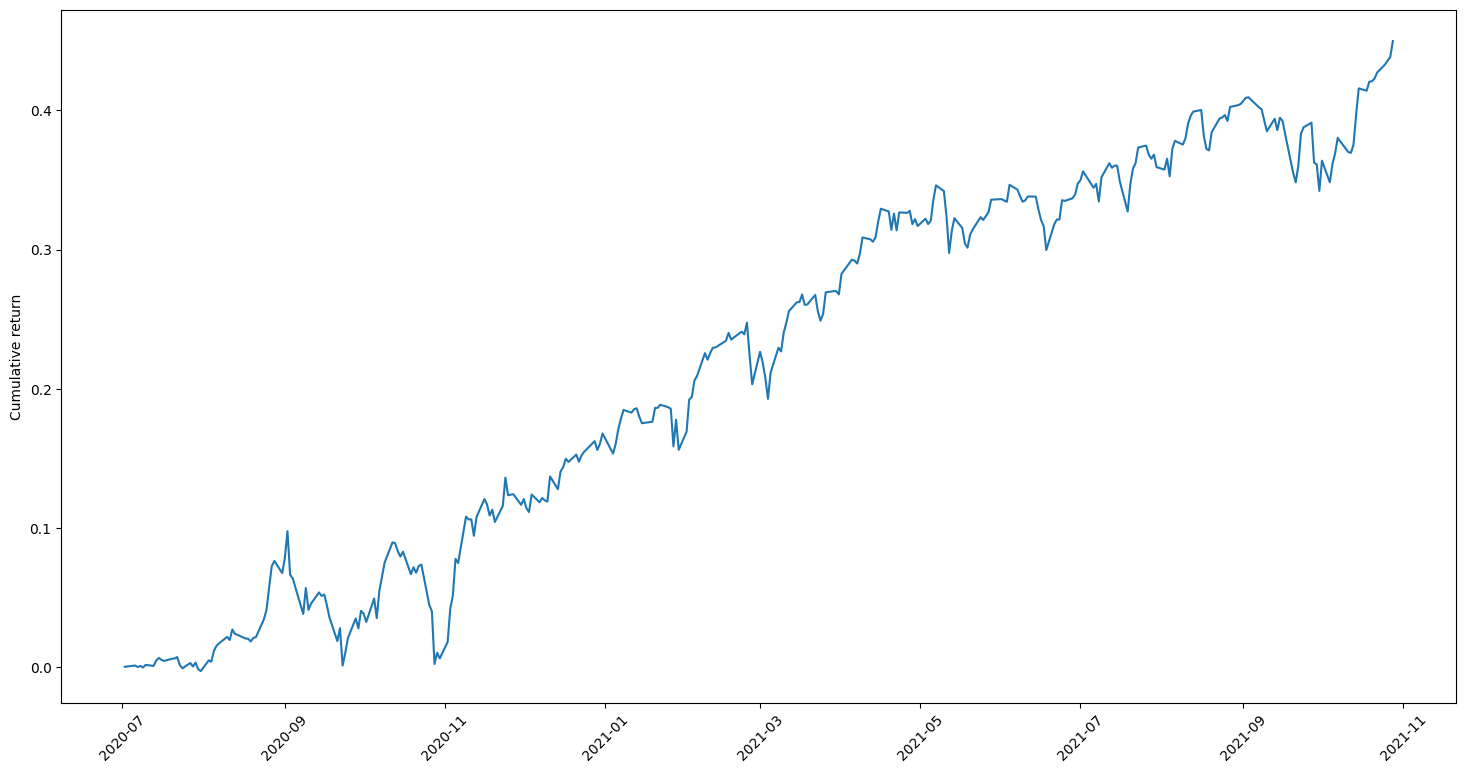

In [95]:
fig = plt.figure(figsize=(18,9))
plt.plot(ret_cum_df)
plt.ylabel('Cumulative return')
plt.tick_params(axis='x', rotation=45)